# 17.7 Spark Streaming: Counting Twitter Hashtags Using the `pyspark-notebook` Docker Stack
* **Stream tweets** and summarize **top-20 hashtags** in dynamically updating **bar chart** 
* **Spark streaming** will read tweets and **summarize hashtags**
* Parts of this sample app communicate with one another via **network sockets**
    * low-level **client/server networking** in which a **client** app communicates with a **server** app over a **network** using techniques **similar to file I/O**
    * **socket** represents one **endpoint of a connection**

### Launching the Docker Container and Installing Tweepy
* For this example, you’ll install the Tweepy library into the Jupyter Docker container.
* Follow Section 17.6.2’s instructions for launching the container and installing Python libraries into it.
* Use the following command to install Tweepy:
>```
pip install tweepy
```

## 17.7.1 Streaming Tweets to a Socket
* The script **`starttweetstream.py`** contains modified **`TweetListener` class** from our Data Mining Twitter presentation
* **Streams** the specified number of tweets and **sends them to a socket on the local computer**
* Requires **`keys.py`** containing **Twitter credentials**

### Executing the Script in the Docker Container
* **File > New > Terminal** 
* `cd work`
* `ipython starttweetstream.py number_of_tweets search_terms`
>```
ipython starttweetstream.py 1000 football
```
* Script displays `"Waiting for connection"` until Spark connects to begin streaming the tweets

### Class TweetListener  
* **Method `on_status`** extracts hashtags, converts to lowercase and creates a space-separated string of hashtags to send to Spark 
* Uses `connection`’s **`send`** method to send string to whatever is reading from that socket 
    * **`send`** expects as its argument a **sequence of bytes**
    * **`hashtags_string.encode('utf-8')`** converts a string to bytes 
* Spark streaming automatically reconstructs the strings

```python
# starttweetstream.py
"""Script to get tweets on topic(s) specified as script argument(s) 
   and send tweet text to a socket for processing by Spark."""
import keys
import socket
import sys
import tweepy

```

```python
class TweetListener(tweepy.StreamListener):
    """Handles incoming Tweet stream."""

    def __init__(self, api, connection, limit=10000):
        """Create instance variables for tracking number of tweets."""
        self.connection = connection
        self.tweet_count = 0
        self.TWEET_LIMIT = limit  # 10,000 by default
        super().__init__(api)  # call superclass's init

    def on_connect(self):
        """Called when your connection attempt is successful, enabling 
        you to perform appropriate application tasks at that point."""
        print('Successfully connected to Twitter\n')

```

```python
    def on_status(self, status):
        """Called when Twitter pushes a new tweet to you."""
        # get the hashtags
        hashtags = []

        for hashtag_dict in status.entities['hashtags']:
            hashtags.append(hashtag_dict['text'].lower())

        hashtags_string = ' '.join(hashtags) + '\n'
        print(f'Screen name: {status.user.screen_name}:')
        print(f'   Hashtags: {hashtags_string}')
        self.tweet_count += 1  # track number of tweets processed
        
        try:
            # send requires bytes, so encode the string in utf-8 format
            self.connection.send(hashtags_string.encode('utf-8'))  
        except Exception as e:
            print(f'Error: {e}')

        # if TWEET_LIMIT is reached, return False to terminate streaming
        return self.tweet_count < self.TWEET_LIMIT
    
    def on_error(self, status):
        print(status)
        return True
   
```     

### Main Application 
* Get the **number of tweets to process** 

```python
if __name__ == '__main__':
    tweet_limit = int(sys.argv[1])  # get maximum number of tweets
```

* Get **socket object** that we’ll use to wait for a connection from the Spark application

```python
    client_socket = socket.socket()  # create a socket 
```

### Main Application (cont.)
* **Bind the socket** to a hostname or IP address and a port number 
* Script **listens here** for an initial connection  

```python
    # app will use localhost (this computer) port 9876
    client_socket.bind(('localhost', 9876))  
```

### Main Application (cont.)
* **Wait until a connection is received** before starting the stream

```python
    print('Waiting for connection')
    client_socket.listen()  # wait for client to connect
    
```

### Main Application (cont.)
* **`accept`** the connection
    * Returns a tuple containing a new **socket object** that the script will use to communicate with the Spark application and the **IP address** of the Spark application’s computer

```python
    # when connection received, get connection/client address
    connection, address = client_socket.accept()  
    print(f'Connection received from {address}')
``` 

### Main Application (cont.)
* Authenticate with Twitter and start the stream

```python
    # configure Twitter access
    auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)
    auth.set_access_token(keys.access_token, keys.access_token_secret)
    
    # configure Tweepy to wait if Twitter rate limits are reached
    api = tweepy.API(auth, wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)               
 
    # create the Stream
    twitter_stream = tweepy.Stream(api.auth, 
        TweetListener(api, connection, tweet_limit))

    # sys.argv[2] is the first search term
    twitter_stream.filter(track=sys.argv[2:]) 
```

* Call **`close`** method on the socket objects to release their resources  

```python
    connection.close()
    client_socket.close()
```

## 17.7.2 Summarizing Tweet Hashtags; Introducing Spark SQL
* Use **Spark streaming** to read the hashtags sent via a socket by the script `starttweetstream.py` and summarize the results.

### Importing the Libraries

In [14]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SparkSession
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

### Utility Function to Get the SparkSession 
* Can use **Spark SQL** to query data in **RDDs**
* **Spark SQL** uses a **Spark `DataFrame`** to get a **table view** of the underlying **RDDs**
* A **`SparkSession`** is used to **create a `DataFrame` from an RDD**
* Can have only one **`SparkSession`** per notebook or app
* We borrowed the following function from the [**_Spark Streaming Programming Guide_**](https://spark.apache.org/docs/latest/streaming-programming-guide.html#dataframe-and-sql-operations)
    * **Defines the correct way to get a `SparkSession` instance** if it already exists or to create one if it does not yet exist 

In [15]:
def getSparkSessionInstance(sparkConf):
    """Spark Streaming Programming Guide's recommended method 
       for getting an existing SparkSession or creating a new one."""
    if ("sparkSessionSingletonInstance" not in globals()):
        globals()["sparkSessionSingletonInstance"] = SparkSession \
            .builder \
            .config(conf=sparkConf) \
            .getOrCreate()
    return globals()["sparkSessionSingletonInstance"]

### Utility Function to Display a Barchart Based on a Spark DataFrame
* Called after Spark processes **each batch of hashtags**
* Clears the previous Seaborn barplot, then displays a new one

In [16]:
def display_barplot(spark_df, x, y, time, scale=1.0, size=(8, 4.5)):
    """Displays a Spark DataFrame's contents as a bar plot."""
    df = spark_df.toPandas()
    
    # remove prior graph when new one is ready to display
    display.clear_output(wait=True) 
    print(f'TIME: {time}')
    
    # create and configure a Figure containing a Seaborn barplot 
    plt.figure(figsize=size)
    sns.set(font_scale=scale)
    barplot = sns.barplot(data=df, x=x, y=y, 
                          palette=sns.color_palette('cool', 20))
    
    # rotate the x-axis labels 90 degrees for readability
    for item in barplot.get_xticklabels():
        item.set_rotation(90)
        
    plt.tight_layout()
    plt.show()

### Utility Function to Summarize the Top-20 Hashtags So Far 
* In **Spark streaming**, a **`DStream`** is a **sequence of `RDD`s** 
* Each **`DStream`** represents **mini-batch** of data to process
* Can call a **function** to **perform a task** for **every RDD**
* **Function `count_tags`** will 
    * **summarize hashtag counts** in an **RDD**
    * **add** them to the **current totals** (maintained by the **`SparkSession`**)
    * display an updated **top-20 barplot**

In [17]:
def count_tags(time, rdd):
    """Count hashtags and display top-20 in descending order."""
    try:
        # get SparkSession
        spark = getSparkSessionInstance(rdd.context.getConf()) 
        
        # map hashtag string-count tuples to Rows 
        rows = rdd.map(
            lambda tag: Row(hashtag=tag[0], total=tag[1])) 
        
        # create a DataFrame from the Row objects
        hashtags_df = spark.createDataFrame(rows)

        # create a temporary table view for use with Spark SQL
        hashtags_df.createOrReplaceTempView('hashtags')
        
        # use Spark SQL to get the top 20 hashtags in descending order
        top20_df = spark.sql(
            """select hashtag, total 
               from hashtags 
               order by total desc, hashtag asc 
               limit 20""")
        display_barplot(top20_df, x='hashtag', y='total', time=time)
    except Exception as e:
        print(f'Exception: {e}')


### Utility Function to Summarize the Top-20 Hashtags So Far (cont.)
1. Get the **`SparkSession`** by calling **`getSparkSessionInstance`** with the **`SparkContext`’s configuration information**
    * Every **RDD** can access its **`SparkContext`** via the **`context`**
2. **`map`** the `RDD`'s data to **`Row`** objects
    * `RDD`s in this example contain **tuples of hashtags and counts**
    * **`Row` constructor** uses the **keyword argument names** as **column names**
3. Create a **Spark `DataFrame`** containing the **`Row` objects** for use with **Spark SQL**
4. **Create a table view** of the **`DataFrame`**
    * Enables Spark SQL to query a **`DataFrame`** like a table in an **relational database**
5. Query the data using **Spark SQL**
    * [Details of Spark SQL’s syntax](https://spark.apache.org/sql/)
    * **`SparkSession` `sql` method** performs a **query** 
    * Returns a new Spark **`DataFrame`** containing the results
6. Pass the **Spark `DataFrame`** to `display_barplot` utility function

### Getting the `SparkContext` 
* The rest of the code in this example sets up **Spark streaming** to read text from the **`starttweetstream.py` script** and specifies **how to process the tweets**
* Create the **`SparkContext`** 

In [18]:
sc = SparkContext()

### Getting the StreamingContext 
* For **Spark streaming**, create a **`StreamingContext`** with following arguments
    * **`SparkContext`** 
    * **batch interval** in seconds&mdash;PySpark docs say this **should be at least 10**
* For **performance-related issues**, such as **batch intervals**, see the [Performance Tuning section of the **_Spark Streaming Programming Guide_**](https://spark.apache.org/docs/latest/streaming-programming-guide.html#performance-tuning)

In [19]:
ssc = StreamingContext(sc, 10)

### Setting Up a Checkpoint to Maintain State
* Spark streaming **does not maintain state** as you process stream of RDDs
* It **_can_ maintain state** via **Spark checkpointing** 
* Enables **stateful transformations**
    * Such as **summarizing collected data** in this example 

In [20]:
import time
ssc.checkpoint(f'checkpoint{time.time()}')  

* In a **cloud-based cluster**, you’d specify a **location within HDFS** 
* In the **Jupyter Docker stack**, Spark creates checkpoint folder in current folder 
* [More checkpointing details](https://spark.apache.org/docs/latest/streaming-programming-guide.html#checkpointing)

### Connecting to the Stream via a Socket
* `StreamingContext` method **`socketTextStream`** **connects to a socket** to receive data stream 
* Returns a **`DStream`** that receives the data

In [21]:
stream = ssc.socketTextStream('localhost', 9876)

### Tokenizing the Lines of Hashtags
* Use **functional style** with a **`DStream`** to specify **processing steps** for **streaming data**
* **`flatmap`** space-separated lines of hashtags into **new `DStream`** of **individual hashtags**

In [22]:
tokenized = stream.flatMap(lambda line: line.split())

### Mapping the Hashtags to Tuples of Hashtag-Count Pairs 
* **`map`** each hashtag to a **hashtag-count tuple** with an initial count **`1`**

In [23]:
mapped = tokenized.map(lambda hashtag: (hashtag, 1))

### Totaling the Hashtag Counts So Far
* **`updateStateByKey`** receives a **two-argument `lambda`** 
* **Totals counts** for a given **key** and **adds** them to the **prior total** for that **key**

In [24]:
hashtag_counts = mapped.updateStateByKey(
    lambda counts, prior_total: sum(counts) + (prior_total or 0)) 

### Specifying the Method to Call for Every RDD
* **`foreachRDD`** passes every processed **RDD** to function **`count_tags`**, which **summarizes top-20 hashtags** so far in a **barplot**

In [25]:
hashtag_counts.foreachRDD(count_tags)

### Starting the Spark Stream
* **`StreamingContext`’s `start` method** begins the streaming process

<!--
### Sample barplot 
![Sample barplot produced while processing a stream of tweets about football](./ch16images/TwitterHashtags.png "Sample barplot produced while processing a stream of tweets about football")
-->

TIME: 2019-07-29 15:50:50


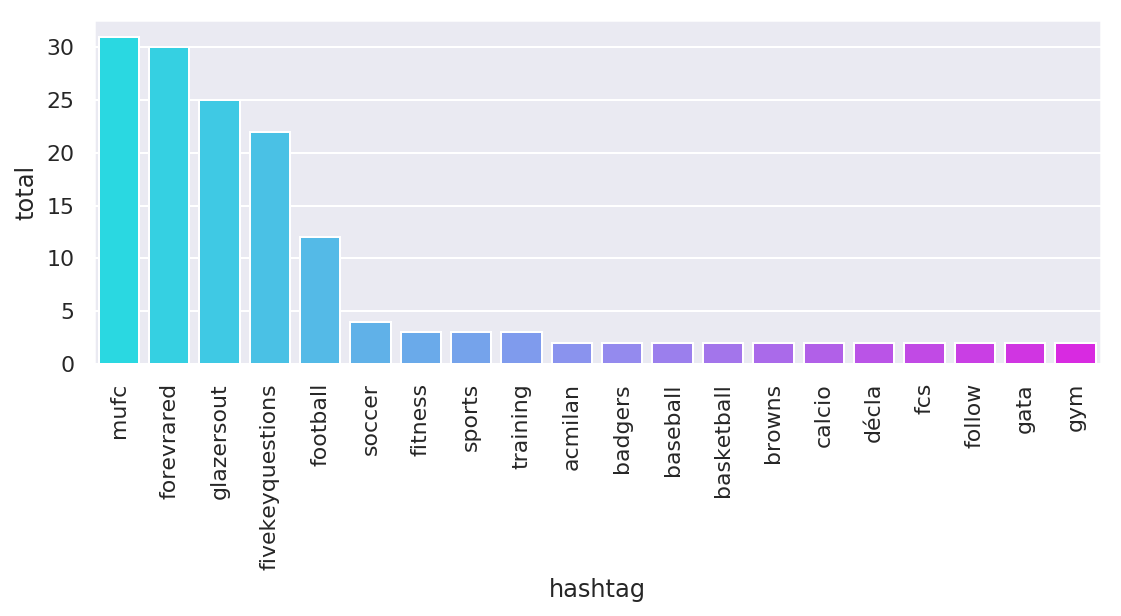

In [26]:
ssc.start()  # start the Spark streaming

------
&copy;1992&ndash;2020 by Pearson Education, Inc. All Rights Reserved. This content is based on Chapter 5 of the book [**Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and the Cloud**](https://amzn.to/2VvdnxE).

DISCLAIMER: The authors and publisher of this book have used their 
best efforts in preparing the book. These efforts include the 
development, research, and testing of the theories and programs 
to determine their effectiveness. The authors and publisher make 
no warranty of any kind, expressed or implied, with regard to these 
programs or to the documentation contained in these books. The authors 
and publisher shall not be liable in any event for incidental or 
consequential damages in connection with, or arising out of, the 
furnishing, performance, or use of these programs.                  